In [1]:
%pip install "calcbench-api-client[Pandas]"

Note: you may need to restart the kernel to use updated packages.


In [39]:
import pyarrow.parquet as pq
import pyarrow.compute as pc
import pyarrow as pa
import numpy as np
import calcbench as cb
from ipydatagrid import DataGrid
from qgridnext import show_grid
from scipy.stats import zscore

### File is the Calcbench Point-In-Time data, see https://github.com/calcbench/notebooks/blob/master/standardized_numeric_point_in_time.ipynb
### Talk to us@calcbench.com if you want a historical file.

In [5]:
d = pq.read_table("C:/Users/andre/Downloads/standardized_data.parquet")

In [6]:
# Only dealing with Revenue for now
expr = pc.field("metric") == "Revenue"

In [7]:
revenue = d.filter(expr).to_pandas()

In [8]:
revenue["value"] = revenue["value"].astype(float)

In [9]:
# Remove small companies

revenue = revenue[revenue["value"] > 1e7]

In [10]:
# Quarterly only
revenue = revenue[~revenue.index.get_level_values("fiscal_period").str.endswith("-0")]

## Add SIC Code meta-data

In [17]:
company_data = cb.companies(entire_universe=True)
merged = revenue.reset_index().merge(
    company_data[["ticker", "sic_code"]], right_on=["ticker"], left_on=["ticker"]
)[["ticker", "period_end", "sic_code", "value"]]

##### Split SIC code into levels, GICs codes would probably be better but Calcbench does not have them
###### https://www.sec.gov/corpfin/division-of-corporation-finance-standard-industrial-classification-sic-code-list

In [18]:
merged["top_level_SIC_code"] = merged["sic_code"].floordiv(1000).astype("string")
merged["second_level_SIC_code"] = (
    (merged["sic_code"] % 1000).floordiv(100).astype("string")
)
merged["third_level_SIC_code"] = (
    (merged["sic_code"] % 100).floordiv(10).astype("string")
)
merged["fourth_level_SIC_code"] = (merged["sic_code"] % 10).astype("string")

In [19]:
merged["ds"] = (merged["period_end"] + pd.offsets.QuarterEnd()).dt.normalize()

In [20]:
merged = merged[
    ~merged.isnull().T.any()
]  # get rid of rows with any null values, the model builder does not like nulls

In [15]:
# only get retail companies 
merged = merged[merged['top_level_SIC_code'] == '5']

In [21]:
# Get first record, there are revisions in the Calcbench data set.
merged = merged.groupby(["ticker", "ds"]).first()

In [35]:
merged.to_parquet("revenue_data.parquet")

<Axes: xlabel='ticker,ds'>

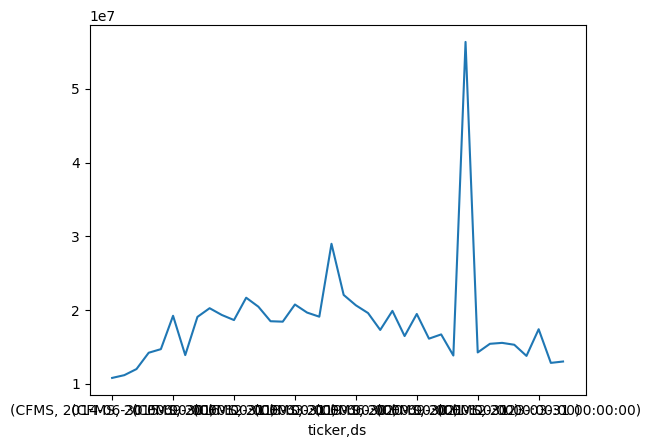

In [60]:
merged.query('ticker == "CFMS"')['value'].plot()

In [41]:
z_scores = merged.groupby("ticker")["value"].transform(lambda x: zscore(x))

<Axes: xlabel='ds'>

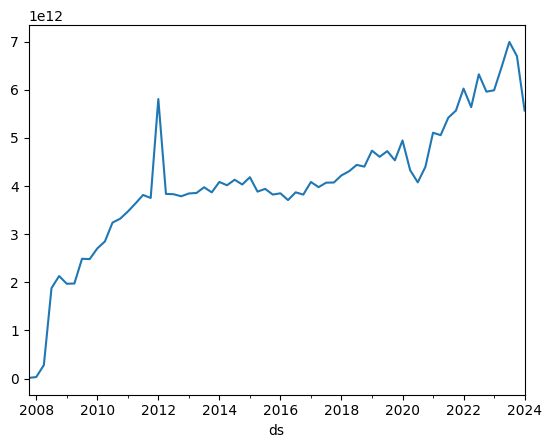

In [66]:
merged[z_scores < 4].groupby("ds")["value"].sum().plot()